In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time

In [22]:
def generate_data(m, n, *, poor_conditioning=False):
    assert m < n, "Number of constraints must be less than number of variables."
    A = np.random.randn(m, n)
    # Ensure last row is positive => problem is bounded below
    # because 1^T x = 1 and x >= 0 restricts the feasible region to be compact
    A[m - 1, :] = np.abs(A[m - 1, :])
    assert np.linalg.matrix_rank(A) == m, "Matrix A must have full row rank."

    if not poor_conditioning:
        x0 = np.random.rand(n) + 0.1
    else:
        x0 = np.exp(np.random.randn(n) * 2)  # log-normal with high variance

    b = A @ x0
    c = np.random.randn(n)
    return A, b, c, x0


def generate_data_infeasible(m, n):
    A, b, c, x0 = generate_data(m, n)
    b[-1] = -1  # Make last constraint infeasible
    return A, b, c, x0

In [25]:
# Test data solvability

m, n = 5, 10


def test_feasibility(gen_func):
    A, b, c, _ = gen_func(m, n)
    x = cp.Variable(n)
    constraints = [A @ x == b, x >= 0]
    objective = cp.Minimize(c @ x)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return prob.status


for _ in range(5):
    status_feasible = test_feasibility(generate_data)
    assert status_feasible == cp.OPTIMAL, "Feasible problem not solved optimally."
    status_infeasible = test_feasibility(generate_data_infeasible)
    assert status_infeasible == cp.INFEASIBLE, "Infeasible problem not detected."

In [3]:
def newton_centering(A, b, c, x0, t=1, *, tol=1e-6, alpha=0.1, beta=0.7):

    def f(x):
        return t * c @ x - np.sum(np.log(x))

    def grad_f(x):
        return t * c - 1 / x

    # ∇²f(x) = diag(1 / x ** 2)
    # ∇²f(x)^(-1) = diag(x ** 2)
    # def hess_inv(x):
    # Improve conditioning of the hessian matrix
    # return x**2, 1e-12)

    x = x0.copy()
    f_x = f(x)
    f_x_history = [f_x]
    lambda_sq_history = []

    while True:
        # Form the full system because block elimination is unstable
        KKT = np.block(
            [
                [np.diag(1 / x**2), A.T],
                [A, np.zeros((A.shape[0], A.shape[0]))],
            ]
        )
        rhs = -np.concatenate([grad_f(x), np.zeros(A.shape[0])])
        sol = np.linalg.solve(KKT, rhs)
        step = sol[: x.shape[0]]
        nu = sol[x.shape[0] :]
        lambda_sq = -step @ grad_f(x)

        if lambda_sq <= tol * 2:
            break

        # Backtracking line search
        u = 1.0
        while np.min(x + u * step) <= 0:
            u *= beta
        while f(x + u * step) > f_x + alpha * u * grad_f(x) @ step:
            u *= beta
        x += u * step
        f_x = f(x)
        f_x_history.append(f_x)
        lambda_sq_history.append(lambda_sq)
        # print(
        #     f"Newton iter: f(x)={f_x:.4f}, lambda^2={lambda_sq:.4e}, step size={u:.4e}"
        # )

    return x, nu, f_x_history, lambda_sq_history

In [43]:
m, n = 100, 500
A, b, c, x0 = generate_data(m, n, poor_conditioning=True)
x_star, nu_star, f_x_history, lambda_sq_history = newton_centering(A, b, c, x0)

# Sanity check
x_cvx = cp.Variable(n)
constraints = [A @ x_cvx == b]
objective = cp.Minimize(c @ x_cvx - cp.sum(cp.log(x_cvx)))
problem = cp.Problem(objective, constraints)
problem.solve()
print(f"CVXPY optimal point: {x_cvx.value[:4]} ...")
print(f"Newton optimal point: {x_star[:4]} ...")
print(f"L2 distance between solutions: {np.linalg.norm(x_star - x_cvx.value, 2)}")
# assert np.allclose(x_star, x_cvx.value, rtol=1e-3)

# KKT optimality check
residual_primal = np.linalg.norm(A @ x_star - b, 2)
residual_dual = np.linalg.norm(c - 1 / x_star + A.T @ nu_star, 2)
print("Checking KKT conditions:")
print(f"Primal residual: {residual_primal}")
print(f"Dual residual: {residual_dual}")

CVXPY optimal point: [168.23520964   0.24282689   2.60489859   0.64201687] ...
Newton optimal point: [168.23536648   0.24282693   2.60491226   0.64201693] ...
L2 distance between solutions: 0.001150599521146038
Checking KKT conditions:
Primal residual: 9.115330076267924e-12
Dual residual: 5.203333117509068e-05


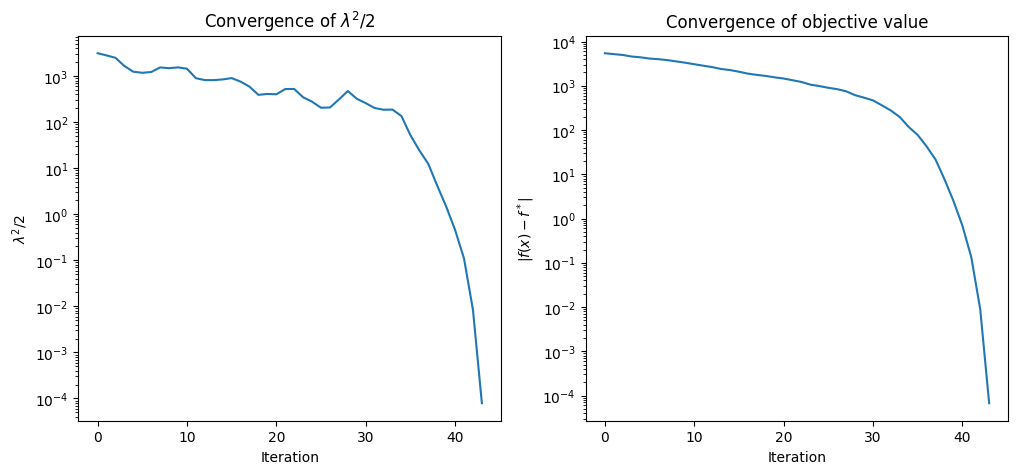

In [44]:
# Plot lambda^2/2 vs iteration, and error vs iteration
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].semilogy(np.array(lambda_sq_history) / 2)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(r"$\lambda^2/2$")
ax[0].set_title(r"Convergence of $\lambda^2/2$")
ax[1].semilogy(np.abs(np.array(f_x_history[:-1]) - problem.value))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel(r"$|f(x) - f^*|$")
ax[1].set_title("Convergence of objective value")
plt.show()

In [34]:
def barrier_method(A, b, c, x0, *, mu=10, tol=1e-4):
    _, n = A.shape
    x = x0.copy()
    t = 1.0
    duality_gap_history = []
    while True:
        x, nu, _, lambda_sq_history = newton_centering(A, b, c, x, t=t)
        num_newton_steps = len(lambda_sq_history)
        duality_gap_history += [n / t] * num_newton_steps
        if n / t < tol:
            break
        t *= mu

    return x, nu, duality_gap_history

In [7]:
# Test barrier's method
m, n = 100, 500
A, b, c, x0 = generate_data(m, n)
x_star, nu_star, duality_gap_history = barrier_method(A, b, c, x0, mu=10, tol=1e-3)

# Sanity check
x_cvx = cp.Variable(n)
constraints = [A @ x_cvx == b, x_cvx >= 0]
objective = cp.Minimize(c @ x_cvx)
problem = cp.Problem(objective, constraints)
problem.solve()
print(f"CVXPY optimal point: {x_cvx.value[:4]} ...")
print(f"Newton optimal point: {x_star[:4]} ...")
print(f"L2 distance between solutions: {np.linalg.norm(x_star - x_cvx.value, 2)}")
# assert np.allclose(x_star, x_cvx.value, rtol=1e-3)

CVXPY optimal point: [6.80670370e-08 2.41167460e-08 9.31662535e-09 5.12339571e-09] ...
Newton optimal point: [3.92355300e-06 1.34211814e-06 5.95316843e-07 3.52747020e-07] ...
L2 distance between solutions: 0.014583672224223503


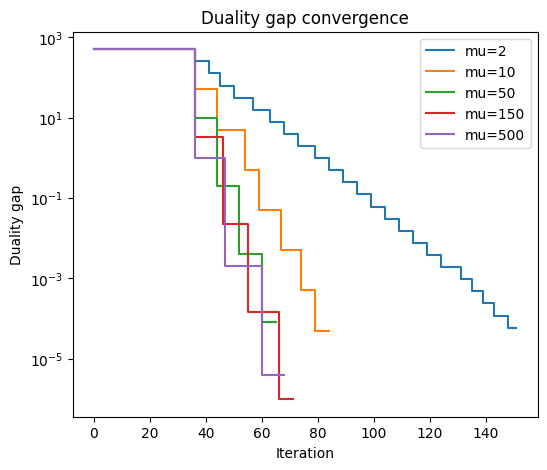

In [ ]:
m, n = 100, 500
A, b, c, x0 = generate_data(m, n, poor_conditioning=True)

# Compare the effects of different mu values
mus = [2, 10, 50, 150, 500]
duality_gap_histories = []
for mu in mus:
    _, _, duality_gap_history = barrier_method(A, b, c, x0, mu=mu, tol=1e-3)
    duality_gap_histories.append(duality_gap_history)


# Plot duality gap history
fig, ax = plt.subplots(figsize=(6, 5))
for mu, duality_gap_history in zip(mus, duality_gap_histories):
    ax.semilogy(duality_gap_history, label=f"mu={mu}", drawstyle="steps-post")
ax.set_xlabel("Iteration")
ax.set_ylabel("Duality gap")
ax.set_title("Duality gap convergence")
ax.legend()
plt.show()

In [40]:
def solve_lp(A, b, c):
    m, n = A.shape

    # Phase I
    # Check if Ax = b is feasible
    x0 = np.linalg.lstsq(A, b, rcond=None)[0]
    if not np.allclose(A @ x0, b):
        raise ValueError("The LP is infeasible.")

    t0 = 2 + np.max([0, -np.min(x0)])
    z0 = x0 + (t0 - 1) * np.ones(n)
    w0 = np.hstack([z0, t0])
    c_phase_1 = np.hstack([np.zeros(n), 1])
    A_phase_1 = np.hstack([A, -A @ np.ones((n, 1))])
    b_phase_1 = b - A @ np.ones(n)
    w_phase_1 = barrier_method(A_phase_1, b_phase_1, c_phase_1, w0)[0]
    z_phase_1 = w_phase_1[:-1]
    t_phase_1 = w_phase_1[-1]
    if t_phase_1 >= 1:
        raise ValueError("The LP is infeasible.")
    x_phase_1 = z_phase_1 + (1 - t_phase_1)

    # Phase II
    x_opt, _, _ = barrier_method(A, b, c, x_phase_1)
    return x_opt

In [41]:
# Test LP solver on a feasible problem

m, n = 100, 500
A, b, c, _ = generate_data(m, n, poor_conditioning=False)
x_opt = solve_lp(A, b, c)
# Sanity check
x_cvx = cp.Variable(n)
constraints = [A @ x_cvx == b, x_cvx >= 0]
objective = cp.Minimize(c @ x_cvx)
problem = cp.Problem(objective, constraints)
problem.solve()
print(f"CVXPY optimal point: {x_cvx.value[:4]} ...")
print(f"LP solver optimal point: {x_opt[:4]} ...")
print(f"L2 distance between solutions: {np.linalg.norm(x_opt - x_cvx.value, 2)}")

CVXPY optimal point: [2.32715301e-08 1.80415715e+00 3.29940584e-09 1.38926813e-08] ...
LP solver optimal point: [8.83269639e-08 1.80425523e+00 2.62613349e-08 6.04246244e-08] ...
L2 distance between solutions: 0.0018276860758808498


In [28]:
# Test LP solver on an infeasible problem

m, n = 100, 500
A, b, c, _ = generate_data_infeasible(m, n)
try:
    x_opt = solve_lp(A, b, c)
    assert False, "Infeasible problem not detected."
except ValueError as e:
    print(f"LP solver correctly detected infeasibility: {e}")

LP solver correctly detected infeasibility: The LP is infeasible.


In [35]:
# Test LP solver correctness on multiple problems
num_tests = 20
m, n = 50, 200
for _ in range(num_tests):
    A, b, c, _ = generate_data(m, n)
    x_opt = solve_lp(A, b, c)

    x_cvx = cp.Variable(n)
    constraints = [A @ x_cvx == b, x_cvx >= 0]
    objective = cp.Minimize(c @ x_cvx)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    assert (
        np.linalg.norm(x_opt - x_cvx.value, 2) < 1e-3
    ), f"LP solver produced incorrect solution: distance={np.linalg.norm(x_opt - x_cvx.value, 2)}"

In [37]:
# Benchmark my LP solver against CVXPY

m, n = 50, 200
feasible_problems = [generate_data(m, n) for _ in range(10)]
infeasible_problems = [generate_data_infeasible(m, n) for _ in range(10)]

my_start_time = time.perf_counter()
for A, b, c, _ in feasible_problems:
    x_my = solve_lp(A, b, c)
for A, b, c, _ in infeasible_problems:
    try:
        x_my = solve_lp(A, b, c)
        assert False, "Infeasible problem not detected."
    except ValueError:
        pass
my_end_time = time.perf_counter()

cvx_start_time = time.perf_counter()
for A, b, c, _ in feasible_problems:
    x_cvx = cp.Variable(n)
    constraints = [A @ x_cvx == b, x_cvx >= 0]
    objective = cp.Minimize(c @ x_cvx)
    problem = cp.Problem(objective, constraints)
    problem.solve()
for A, b, c, _ in infeasible_problems:
    x_cvx = cp.Variable(n)
    constraints = [A @ x_cvx == b, x_cvx >= 0]
    objective = cp.Minimize(c @ x_cvx)
    problem = cp.Problem(objective, constraints)
    problem.solve()
    assert problem.status == cp.INFEASIBLE, "Infeasible problem not detected."
cvx_end_time = time.perf_counter()

print(f"My LP solver time: {my_end_time - my_start_time:.4f} seconds")
print(f"CVXPY LP solver time: {cvx_end_time - cvx_start_time:.4f} seconds")

My LP solver time: 2.0616 seconds
CVXPY LP solver time: 0.2678 seconds
